In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [35]:
#Change the values to run the experiment

experiment = 1 #1-> BANKEX , 2 ->Activities
f = 20 #Size of future window in days. Change f for the number of steps-ahead. 1 or 20.
thepath = 'models' #Change the path to where you want to save the models

NameError: name 'os' is not defined

Suggested citation: Velarde, G., Brañez, P., Bueno, A., Heredia, R., & Lopez, M. (Accepted). An Open-Source and Reproducible Implementation of GRU and LSTM Networks for Time Series Forecasting. ITISE CONFERENCE: 8th International Conference on Time Series and Forecasting, June 27th-30th, 2022.

MIT License

Copyright (c) [2021] [Gissel Velarde, Pedro Brañez, Alejandro Bueno, Rodrigo Heredia, & Mateo Lopez]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [37]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from numpy import genfromtxt
from pandas_datareader import data as pdr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu
import os

Definitions

In [4]:
def GRU_Model(output_window, input_shape):
  model = Sequential()
  model.add(GRU(128, return_sequences=False, input_shape=input_shape))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [5]:
def LSTM_Model(output_window, input_shape):
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=input_shape))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [6]:
#Based on: Computer Science: Stock Price Prediction Using Python & Machine Learning. https://www.youtube.com/watch?v=QIUxPv5PJOY (2019), accessed 25 January,
2022
def data_preparation(w, scaled_data, N, f):
  X=[]
  Y=[]
  window = w + f
  Q = len(scaled_data)
  for i in range(Q-window-f):
    X.append(scaled_data[i:i+window, :])
    Y.append(scaled_data[i+window:i+window+f, 0])

  X = np.array(X)
  Y = np.array(Y)

  X = np.reshape(X, (X.shape[0],X.shape[1],X.shape[2]))

  trainX, trainY = X[:N], Y[:N]
  testX, testY = X[N:], Y[N:]

  return trainX, trainY, testX, testY, X

In [24]:
#Repeats the last known value f times
def baselinef(U,f):
  last = U.shape[0]
  yhat = np.zeros((last, f))
  for j in range(0,last):
    yhat[j,0:f] = np.repeat(U[j, -1, 0], f)
  return yhat

In [8]:
#Directional accuracy
#From https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
def mda(actual: np.ndarray, predicted: np.ndarray):
  return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [9]:
#Normalize data between 0 and 1
def scaleit(DATAX):
  mima = np.zeros((DATAX.shape[0], 2)) #To save min and max values
  for i in range(DATAX.shape[0]):
    mima[i,0],mima[i,1] = DATAX[i,:].min(), DATAX[i,:].max()
    DATAX[i,:] = (DATAX[i,:]-DATAX[i,:].min())/(DATAX[i,:].max()-DATAX[i,:].min())
  return DATAX, mima

In [10]:
#Rescale to original values
def rescaleit(y,mima,i):
  yt = (y*(mima[i,1]-mima[i,0]))+mima[i,0]
  return yt

In [11]:
#Based on https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
#This code is to plot series of different colors
def plot_series(X):
  x = np.arange(len(X))
  n_nodes = X.shape[1] // 2  # 每两个列代表一个节点，所以有 n_nodes 个节点

  # 创建 6 个子图，分别显示每个节点
  fig, axes = plt.subplots(n_nodes, 1, figsize=(10, 12))  # 创建 6 行的子图
  axes = axes.flatten()  # 将 axes 从二维数组转为一维，方便循环访问

  # 使用两种颜色：红色用于 gas，蓝色用于 temp
  gas_color = 'salmon'
  temp_color = 'skyblue'



  for i in range(n_nodes):
        # 每个节点的 gas 和 temp 列
        gas = X[:, 2*i]  # 偶数列，表示 gas
        temp = X[:, 2*i + 1]  # 奇数列，表示 temp
        # 在对应的子图中绘制数据
        axes[i].plot(x, gas, label=f'Node {i+1} Gas', color=gas_color)  # 绘制 gas
        axes[i].plot(x, temp, label=f'Node {i+1} Temp', linestyle='--', color=temp_color)  # 绘制 temp（虚线）
        # 设置每个子图的标题、标签和图例
        axes[i].set_title(f'Node {i+1}')
        axes[i].set_xlabel('Hours')
        axes[i].set_ylabel('Values')
        axes[i].legend(loc='upper right')

  # 调整子图间的间距
  plt.tight_layout()

  # 显示图形
  plt.show()

In [12]:
#Statistical tests
def statisticaltests(s):
  print('LSTM and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,1],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,1], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,1+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,1+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))

In [14]:
if experiment ==1:
  #Retrieve BANKEX dataset
  DATAX = pd.read_excel('data.xlsx', header=None)
  print(DATAX.shape)
  print(DATAX.iloc[6])

  DATAX = DATAX.to_numpy()
  print(DATAX[:3])

(17520, 12)
0     0.165105
1     0.581315
2     0.979966
3     0.645125
4    -1.395276
5     0.681634
6     0.795695
7     0.695301
8     0.508449
9     0.677176
10    0.774497
11    0.523330
Name: 6, dtype: float64
[[ 0.44233576 -0.55871222  0.75462755 -0.19955262 -0.21856493 -0.59980192
   1.35118079 -0.13416392  1.11024101 -0.37108474  1.85920441 -0.97931249]
 [ 0.31280141 -0.21801452  0.77160955 -0.11910711  0.00486978 -0.5093476
   1.17519698  0.04681018  0.67920661 -0.24591932  3.21609271 -0.82753039]
 [ 0.21902653  0.01785312  0.76071191 -0.02525401  0.20327138 -0.25306039
   1.39425855  0.0920537   0.44618238 -0.0581712   3.74194866 -0.5391444 ]]


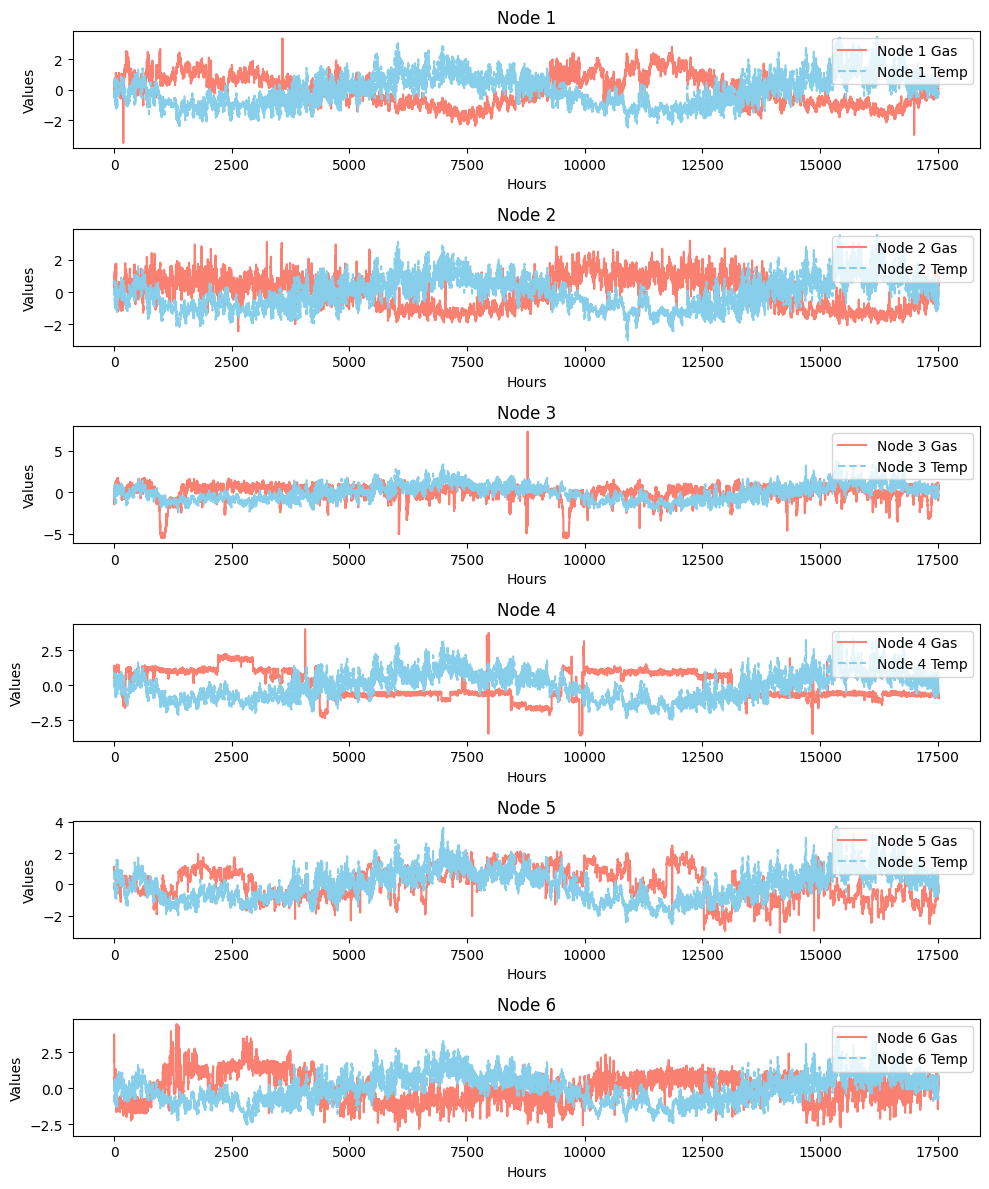

In [15]:
plot_series(DATAX)

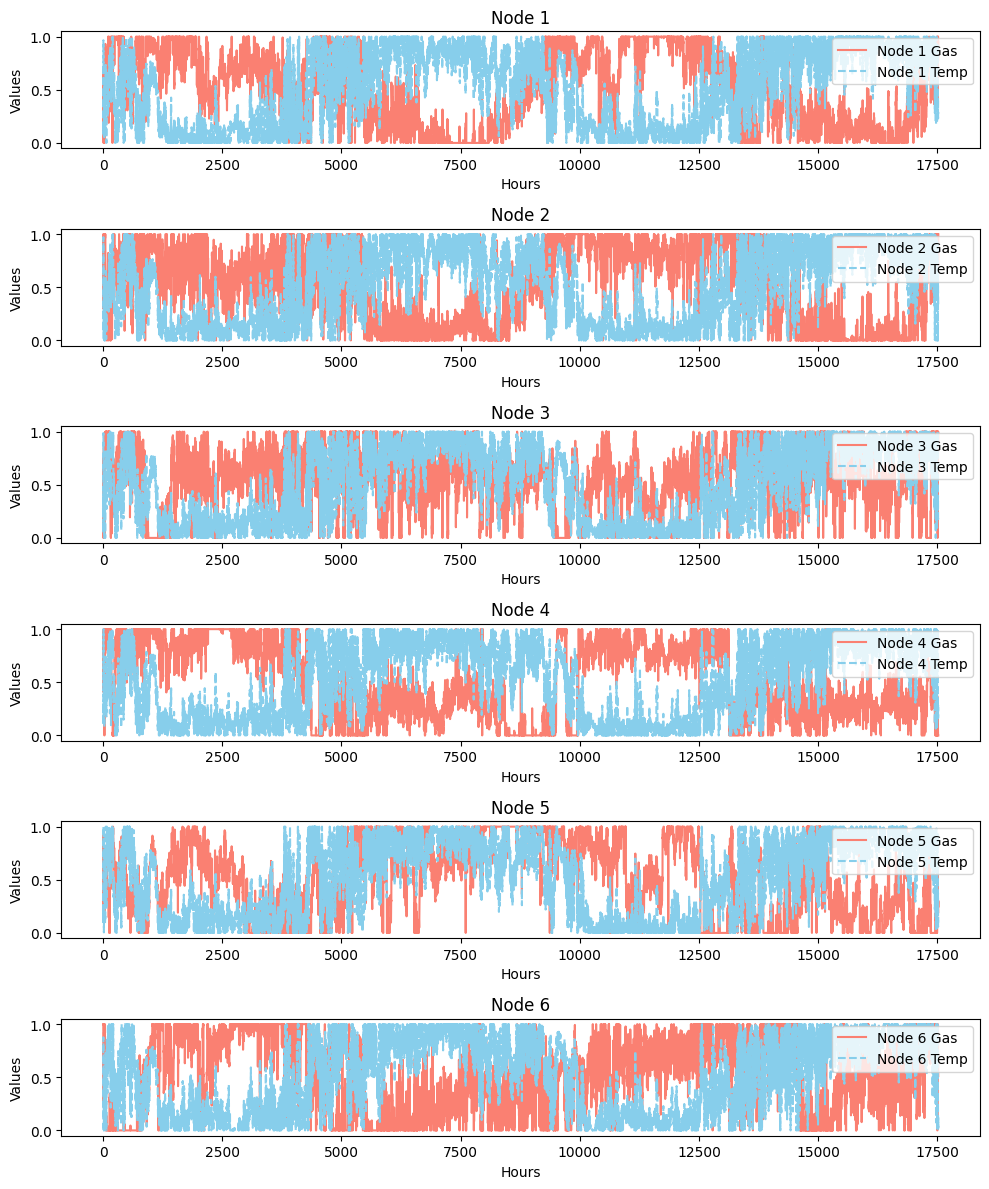

In [16]:
#Normalize data between 0 and 1
DATAX, mima = scaleit(DATAX)
plot_series(DATAX)

In [17]:
selected_series = 0 #Select one signal arbitrarily to train the dataset
scaled_data = DATAX[:, selected_series]
scaled_data = np.reshape(scaled_data, (len(scaled_data),1))
scaled_data.shape

(17520, 1)

In [18]:
#w < N < Q
window = 60 #Size of the window in days
test_samples = 251 #Number of test samples
N = len(scaled_data) - test_samples - window

In [19]:
trainX, trainY, testX, testY, X = data_preparation(window, scaled_data, N,f)

In [20]:
input_shape = (trainX.shape[1], trainX.shape[2])
lstm_model = LSTM_Model(f,input_shape)
gru_model = GRU_Model(f,input_shape)
epochs = 200

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,140 (270.08 KB)

 Trainable params: 69,140 (270.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,884 (206.58 KB)

 Trainable params: 52,884 (206.58 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
batch_size = 64
# Train LSTM model
lstm_trained = lstm_model.fit(trainX, trainY, shuffle=True, epochs=epochs, batch_size = batch_size, validation_data=(testX, testY))
# Train GRU model
gru_trained = gru_model.fit(trainX, trainY, shuffle=True, epochs=epochs, batch_size = batch_size, validation_data=(testX, testY))

Epoch 1/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0021 - val_loss: 0.0231
Epoch 2/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0034 - val_loss: 0.0232
Epoch 3/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0020 - val_loss: 0.0231
Epoch 4/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0019 - val_loss: 0.0228
Epoch 5/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0228
Epoch 6/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019 - val_loss: 0.0234
Epoch 7/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020 - val_loss: 0.0231
Epoch 8/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020 - val_loss: 0.0236
Epoch 9/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0020 - val_loss: 0.0236
Epoch 10/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020 - val_loss: 0.0242
Epoch 11/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0035 - val_loss: 0.0206
Epoch 12/200
269/269 ━━━━━━━━━━━━━━━━━

In [25]:
#Testing
num_nodes = 6  # 你有6个节点
results = np.ones((num_nodes, 6))  # 存储6个节点的测试结果，每个节点6个指标(RMSE和MDA)

for node in range(num_nodes):
    # 提取每个节点的数据（每个节点两列数据：gas和temp）
    scaled_data = DATAX[:, node*2:(node*2)+2]  # 选取每个节点的gas和temp
    # 确保数据维度正确：(17520, 2)
    print(f"Node {node+1} data shape: {scaled_data.shape}")
    # 数据预处理，得到测试数据
    _, _, testX, testY, _ = data_preparation(window, scaled_data, N, f)
    # 使用LSTM和GRU模型预测
    y_pred_lstm = lstm_model.predict(testX)
    y_pred_gru = gru_model.predict(testX)
    # 基准模型预测（使用过去已知的最后值作为预测）
    y_baseline = baselinef(testX, f)
    # 确认形状匹配（testY 和预测值y的形状）
    testY = np.reshape(testY, (testY.shape[0], testY.shape[1]))
    # 打印形状，确认无误
    print(f"TestY shape: {testY.shape}, LSTM shape: {y_pred_lstm.shape}, GRU shape: {y_pred_gru.shape}, Baseline shape: {y_baseline.shape}")
    # 计算RMSE指标
    results[node, 0] = np.sqrt(mean_squared_error(testY, y_pred_lstm))
    results[node, 1] = np.sqrt(mean_squared_error(testY, y_pred_gru))
    results[node, 2] = np.sqrt(mean_squared_error(testY, y_baseline))
    # 计算MDA指标 (方向准确度)
    results[node, 3] = mda(testY, y_pred_lstm)
    results[node, 4] = mda(testY, y_pred_gru)
    results[node, 5] = mda(testY, y_baseline)

# 显示结果
print("Node-wise RMSE and MDA results:")
print("Columns: [RMSE_LSTM, RMSE_GRU, RMSE_Baseline, MDA_LSTM, MDA_GRU, MDA_Baseline]")
print(results)

Node 1 data shape: (17520, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
TestY shape: (211, 20), LSTM shape: (211, 20), GRU shape: (211, 20), Baseline shape: (211, 20)
Node 2 data shape: (17520, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
TestY shape: (211, 20), LSTM shape: (211, 20), GRU shape: (211, 20), Baseline shape: (211, 20)
Node 3 data shape: (17520, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
TestY shape: (211, 20), LSTM shape: (211, 20), GRU shape: (211, 20), Baseline shape: (211, 20)
Node 4 data shape: (17520, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
TestY shape: (211, 20), LSTM shape: (211, 20), GRU shape: (211, 20), Baseline shape: (211, 20)
Node 5 data shape: (17520, 2)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
TestY shape: (211, 20), LSTM shape: (211, 20), GRU shape: (211, 20), Baseline shape: (211,

In [51]:
print('Mean values:')
print(np.mean(results, axis=0))

Mean values:
[0.79408851 0.70235538 0.19418086 0.39400794 0.39150794 0.47563492]


In [28]:
print('Standard Deviation:')
print(np.std(results, axis=0))

Standard Deviation:
[0.19365745 0.11109631 0.04411201 0.08706925 0.07937893 0.09700315]


In [31]:
#Statistical tests
statisticaltests(results)

LSTM and Baseline (RMSE)
U=36.0. p = 0.0021645021645021645
GRU and Baseline (RMSE)
U=36.0. p = 0.0021645021645021645
LSTM and GRU (RMSE)
U=25.0. p = 0.30952380952380953
LSTM and Baseline (DA)
U=10.0. p = 0.24025974025974026
GRU and Baseline (DA)
U=11.0. p = 0.30952380952380953
LSTM and GRU (DA)
U=19.0. p = 0.9372294372294373


In [38]:
#use this code to save the models
thepath = 'models'  # 可修改为你的实际路径
# Create the directory if it doesn't exist
os.makedirs(thepath, exist_ok=True)
# 保存GRU模型
gru_model.save(f'{thepath}/GRU_{f}.keras')

# 保存LSTM模型
lstm_model.save(f'{thepath}/LSTM_{f}.keras')


In [40]:
#Rescale for visual inspection(example: node 1, gas)
feature_index = 0  # 第1个节点gas特征
testY_rescaled = rescaleit(testY, mima, feature_index)
y_pred_lstm_rescaled = rescaleit(y_pred_lstm, mima, feature_index)
y_pred_gru_rescaled = rescaleit(y_pred_gru, mima, feature_index)
y_baseline_rescaled = rescaleit(y_baseline, mima, feature_index)

In [41]:
if f == 1:
  plt.figure(figsize=(12,6))
  # 绘制实际数据
  plt.plot(testY_rescaled[0:100], label='Actual', linewidth=2)
  # 绘制Baseline预测数据
  plt.plot(y_baseline_rescaled[0:100], label='Baseline prediction', linestyle='--')
  # 绘制LSTM预测数据
  plt.plot(y_pred_lstm_rescaled[0:100], label='LSTM prediction', linestyle='--')
  # 绘制GRU预测数据
  plt.plot(y_pred_gru_rescaled[0:100], label='GRU prediction', linestyle='--')
  # 添加图例（位于上方中心）
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
             fancybox=True, shadow=True, ncol=4)
  # 修改坐标轴标签
  plt.xlabel("Hours")
  plt.ylabel("Gas Flow Value")
  # 添加标题
  plt.title("Comparison of Actual vs Predicted Gas Flow Values (First 100 samples)")
  # 显示绘图
  plt.tight_layout()
  plt.show()

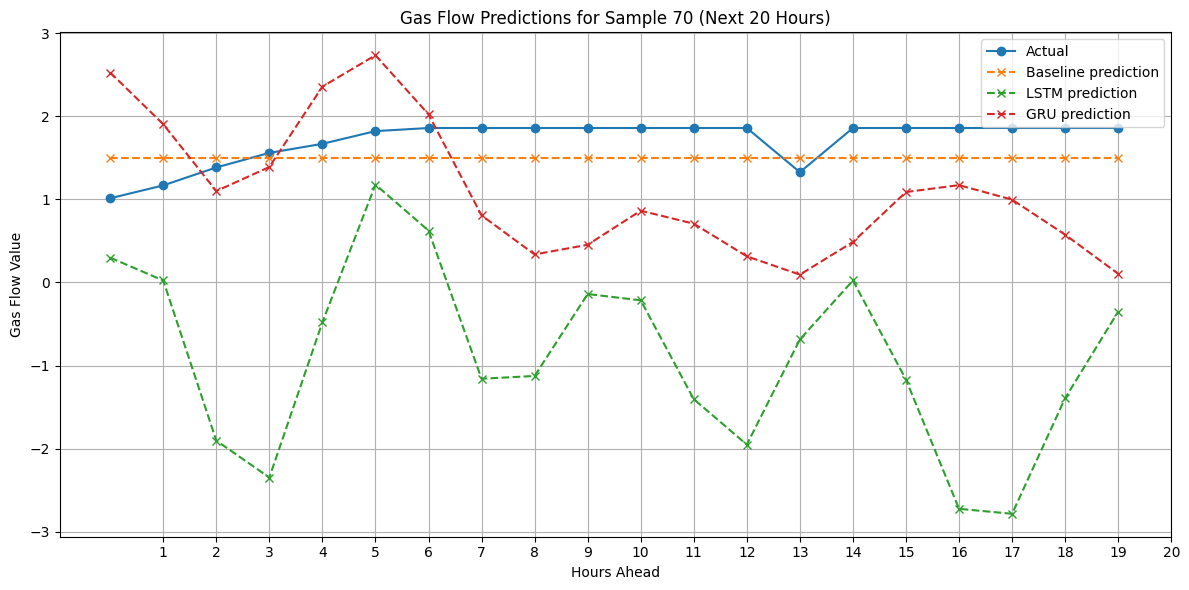

In [46]:
g = 70 #Chooses one of the tests samples
if f == 20:
  plt.figure(figsize=(12,6))
  # 绘制实际值和预测值（未来20个小时的数据）
  plt.plot(testY_rescaled[g,:], label='Actual', marker='o')
  plt.plot(y_baseline_rescaled[g,:], label='Baseline prediction', linestyle='--', marker='x')
  plt.plot(y_pred_lstm_rescaled[g,:], label='LSTM prediction', linestyle='--', marker='x')
  plt.plot(y_pred_gru_rescaled[g,:], label='GRU prediction', linestyle='--', marker='x')

  plt.legend()

  # 调整x轴为小时
  hours = np.arange(1, testY_rescaled.shape[1] + 1)  # 1, 2, ..., 20
  plt.xticks(hours)  # x轴刻度为整数小时

  # 修改轴标签
  plt.xlabel('Hours Ahead')  # 更清晰地表示预测的是未来的小时数
  plt.ylabel('Gas Flow Value')

  # 标题
  plt.title(f'Gas Flow Predictions for Sample {g} (Next 20 Hours)')

  plt.grid(True)
  plt.tight_layout()
  plt.show()

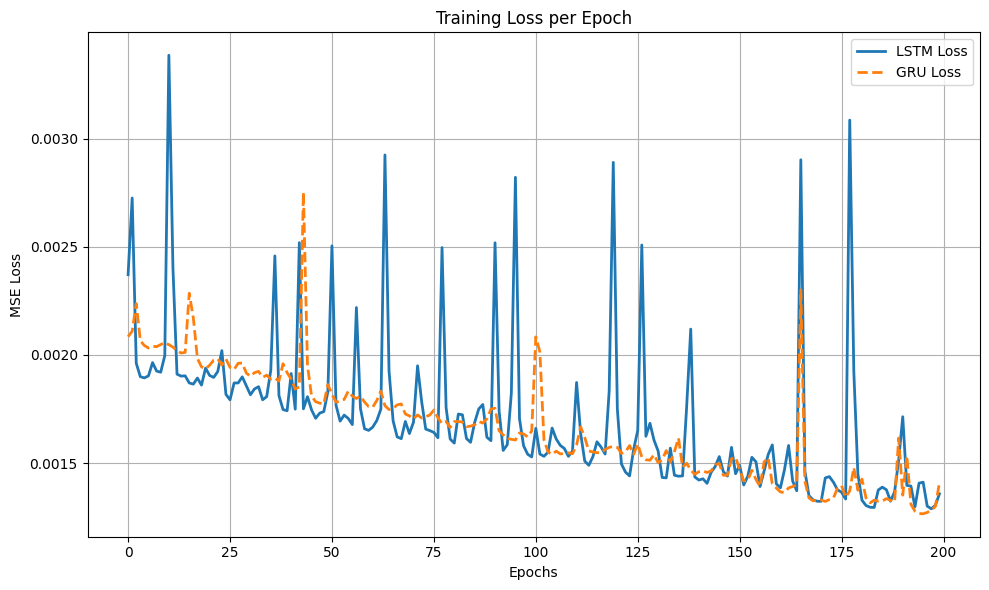

In [47]:
#"""Plot loss function and Predictions"""
plt.figure(figsize=(10, 6))

# 绘制训练损失曲线
plt.plot(lstm_trained.history['loss'], label='LSTM Loss', linewidth=2)
plt.plot(gru_trained.history['loss'], label='GRU Loss', linewidth=2, linestyle='--')

# 图例和标签
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()